In [ ]:
import pandas as pd
import pickle
import datetime as dt
import numpy as np
import matplotlib.pyplot as plt
from dateutil.relativedelta import relativedelta
from sklearn.metrics import roc_auc_score
import statsmodels.api as sm
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_auc_score
import torch
from torch import nn
from torch.utils.data import TensorDataset, DataLoader
from tqdm import trange, tqdm
from sklearn.preprocessing import StandardScaler
import torch.optim as optim
import matplotlib.pyplot as plt

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
relative_path="/content/drive/MyDrive/Credit Risk Analytics/Project3"

# Step 1 - Cleaning the Financial Data

## Step 1.1 Pulling financials

In [ ]:
financials=pd.read_pickle(relative_path + "/"+"compustat financials.pickle")

In [ ]:
financials = financials.rename({'at':'total_assets'}, axis = 1)
financials = financials[~pd.isnull(financials.total_assets)]
financials = financials[financials.total_assets > 0]
print(f'There are {len(financials):,} rows in data')
financials.head()

There are 319,589 rows in data


,gvkey,datadate,fyear,fyr,total_assets,lt,ceq,act,lct,invt,...,prcc_f,freq,pstk,dp,capx,intan,gdwl,txt,dv,urect
0,001004,1991-05-31,1990,5,379.958,186.180,193.778,268.399,79.227,156.133,...,14.124999,Annual,0.0,8.256,8.884,7.115,7.115,6.550,7.651,NaN
1,001009,1990-10-31,1990,10,32.335,26.073,6.262,10.047,8.382,2.355,...,5.999998,Annual,0.0,1.971,5.493,0.000,0.000,0.769,0.808,NaN
2,001010,1990-12-31,1990,12,1728.888,1516.287,210.399,523.502,421.777,36.860,...,NaN,Annual,0.0,56.747,140.385,NaN,0.000,-28.220,0.000,NaN
3,001011,1990-12-31,1990,12,7.784,7.117,0.667,1.247,1.246,0.663,...,1.188000,Annual,0.0,0.700,1.273,1.009,NaN,0.000,0.000,NaN
4,001013,1990-10-31,1990,10,181.665,47.652,134.013,102.525,37.335,33.845,...,16.375000,Annual,0.0,11.980,13.734,NaN,NaN,15.269,0.000,NaN


## Step 1.2 Creating the ratios

The following ratios are the combination of the ratios that our group used in project 2 and also the ratios that given in the homework 2 solution. When I first tried using only the Project 2 ratios, very few met my AUC‐based selection criteria, making it hard to choose factors. Rather than loosen my selection rule, I broadened the pool of input ratios and then applied a stricter AUC threshold.

In [ ]:
### Ratios From HW2 Solutions
financials = financials.sort_values(by=['gvkey', 'datadate']).copy()
financials = financials.reset_index(drop=True)

list_factor_givenhw = [
    'total_debt', 'debt_to_equity', 'debt_to_capital', 'liabilities_to_assets',
    'debt_to_assets', 'interest_coverage', 'free_cash_flow', 'dscr_fcf',
    'roa', 'roe', 'operating_margin', 'operating_margin_alt',
    'net_profit_margin', 'tangible_assets', 'tangible_book_value_to_debt',
    'current_ratio', 'quick_ratio', 'quick_ratio_alt', 'cash_ratio',
    'intan_to_assets', 'goodwill_to_assets', 'ocf_to_debt', 'fcf_to_debt',
    'avg_at', 'accruals', 'accruals_alt', 'inventory_turnover',
    'receivables_turnover', 'asset_turnover', 'book_value_per_share',
    'price_to_book', 'eps', 'price_to_earnings', 'dividend_yield',
    'dividend_payout', 'sg&a_intensity', 'rd_intensity', 'capex_ratio',
    'sales_growth', 'earnings_growth', 'ocf_growth', 'asset_growth',
    'dividend_growth', 'equity_to_assets', 'xsga_to_sales', 'act_norm',
    'lct_norm', 'invt_norm', 'rect_norm', 'ap_norm', 'xint_margin',
    'xrd_intensity', 'xsga_intensity', 'ebit_margin', 'cogs_margin',
    'ni_margin', 'txt_rate', 'oancf_norm', 'fincf_norm', 'capx_norm'
]

# --- Leverage Ratios ---
financials['total_debt'] = financials['dlc'] + financials['dltt']
financials['debt_to_equity'] = financials['total_debt'] / financials['ceq']
financials['debt_to_capital'] = financials['total_debt'] / (financials['total_debt'] + financials['ceq'] + financials.get('pstk', 0)
)
financials['liabilities_to_assets'] = financials['lt'] / financials['total_assets']
financials['debt_to_assets'] = financials['total_debt'] / financials['total_assets']

# --- Coverage Ratio ---
financials['interest_coverage'] = financials['ebit'] / financials['xint']
financials['free_cash_flow'] = financials['oancf'] - financials['capx']
financials['dscr_fcf'] = financials['free_cash_flow'] / financials['xint']

# --- Profitability Ratios ---
financials['roa'] = financials['ni'] / financials['total_assets']
financials['roe'] = financials['ni'] / financials['ceq']
financials['operating_margin'] = financials['oibdp'] / financials['sale']
financials['operating_margin_alt'] = financials['ebit'] / financials['sale']
financials['net_profit_margin'] = financials['ni'] / financials['sale']

# --- Asset Coverage & Quality Ratios ---
financials['tangible_assets'] = (
    financials['total_assets'] - financials['intan'] - financials['gdwl']
)
financials['tangible_book_value_to_debt'] = (
    financials['tangible_assets'] / financials['total_debt']
)

# Liquidity Ratios
financials['current_ratio'] = financials['act'] / financials['lct']
financials['quick_ratio'] = (financials['act'] - financials['invt']) / financials['lct']
financials['quick_ratio_alt'] = (financials['che'] + financials['rect']) / financials['lct']
financials['cash_ratio'] = financials['che'] / financials['lct']

# --- Intangible Ratios ---
financials['intan_to_assets'] = financials['intan'] / financials['total_assets']
financials['goodwill_to_assets'] = financials['gdwl'] / financials['total_assets']

# --- Cash Flow Ratios ---
financials['ocf_to_debt'] = financials['oancf'] / financials['total_debt']
financials['free_cash_flow'] = financials['oancf'] - financials['capx']
financials['fcf_to_debt'] = financials['free_cash_flow'] / financials['total_debt']

# --- Accruals Ratio ---
financials['avg_at'] = financials.groupby('gvkey')['total_assets'].transform(
    lambda x: (x.shift(1) + x) / 2
)
financials['accruals'] = (financials['ni'] - financials['oancf']) / financials['avg_at']
financials['accruals_alt'] = financials['oancf'] / financials['ni']

# --- Efficiency Ratios ---
financials['inventory_turnover'] = financials['cogs'] / financials['invt']
financials['receivables_turnover'] = financials['sale'] / financials['rect']
financials['asset_turnover'] = financials['sale'] / financials['total_assets']

# --- Market Valuation Ratios ---
financials['book_value_per_share'] = financials['ceq'] / financials['csho']
financials['price_to_book'] = (
    financials['prcc_f'] / financials['book_value_per_share']
)

financials['eps'] = financials['ni'] / financials['csho']
financials['price_to_earnings'] = financials['prcc_f'] / financials['eps']

# --- Dividend Ratios ---
financials['dividend_yield'] = financials['dv'] / financials['prcc_f']
financials['dividend_payout'] = financials['dv'] / financials['ni']

# --- Operational Efficiency ---
financials['sg&a_intensity'] = financials['xsga'] / financials['sale']
financials['rd_intensity'] = financials['xrd'] / financials['sale']
financials['capex_ratio'] = financials['capx'] / financials['sale']

# --- Growth Ratios ---
financials['sales_growth'] = financials.groupby('gvkey')['sale'].pct_change(fill_method=None)
financials['earnings_growth'] = financials.groupby('gvkey')['ni'].pct_change(fill_method=None)
financials['ocf_growth'] = financials.groupby('gvkey')['oancf'].pct_change(fill_method=None)
financials['asset_growth'] = financials.groupby('gvkey')['total_assets'].pct_change(fill_method=None)
financials['dividend_growth'] = financials.groupby('gvkey')['dv'].pct_change(fill_method=None)

# --- Other straightforward ratios ---
financials['equity_to_assets'] = financials['ceq'] / financials['total_assets']
financials['xsga_to_sales'] = financials['xsga'] / financials['sale']

# Balance Sheet Items (normalized by total_assets)
financials['act_norm'] = financials['act'] / financials['total_assets']
financials['lct_norm'] = financials['lct'] / financials['total_assets']
financials['invt_norm'] = financials['invt'] / financials['total_assets']
financials['rect_norm'] = financials['rect'] / financials['total_assets']
financials['ap_norm'] = financials['ap'] / financials['total_assets']

# Income Statement Items (normalized by sale)
financials['xint_margin'] = financials['xint'] / financials['sale']
financials['xrd_intensity'] = financials['xrd'] / financials['sale']
financials['xsga_intensity'] = financials['xsga'] / financials['sale']
financials['ebit_margin'] = financials['ebit'] / financials['sale']
financials['cogs_margin'] = financials['cogs'] / financials['sale']
financials['ni_margin'] = financials['ni'] / financials['sale']
financials['txt_rate'] = financials['txt'] / financials['sale']

# Cash Flow Items (normalized by total_assets)
financials['oancf_norm'] = financials['oancf'] / financials['total_assets']
financials['fincf_norm'] = financials['fincf'] / financials['total_assets']
financials['capx_norm'] = financials['capx'] / financials['total_assets']

# Remove infinities
for ratio in list_factor_givenhw:
    financials = financials[(financials[ratio] != np.inf) & (financials[ratio] != -np.inf)]

# Remove NaN values
for ratio in list_factor_givenhw:
    financials = financials[~financials[ratio].isna()]


gvkeys = financials.gvkey.unique()
print(f'There are {len(financials):,} rows in financials')
print(f'There are {len(gvkeys):,} unique companies')

There are 19,247 rows in financials
There are 2,655 unique companies


In [ ]:
### Ratios From Project2
list_factor_new=[
    'gross_margin',
    'de_ratio',
    'asset_turnover',
    'inv_turnover',
    'rect_turnover',
    'ap_turnover',
    'current_ratio',
    'quick_ratio',
    'cash_ratio',
    'ocf_ratio',
    'capx_ratio',
    'rnd_sale_ratio',
    'xsga_sale_ratio',
    'tax_sale_ratio']

# --- Profitability Metrics ---
if {'sale', 'cogs'}.issubset(financials.columns):
    financials['gross_margin'] = (financials['sale'] - financials['cogs']) / financials['sale']

# --- Leverage / Solvency Metrics ---
if {'lt', 'ceq'}.issubset(financials.columns):
    financials['de_ratio'] = financials['lt'] / financials['ceq']

# --- Efficiency / Operating Metrics ---
if {'sale', 'total_assets'}.issubset(financials.columns):
    financials['asset_turnover'] = financials['sale'] / financials['total_assets']
if {'sale', 'invt'}.issubset(financials.columns):
    financials['inv_turnover'] = financials['sale'] / financials['invt']
if {'sale', 'rect'}.issubset(financials.columns):
    financials['rect_turnover'] = financials['sale'] / financials['rect']
if {'cogs', 'ap'}.issubset(financials.columns):
    financials['ap_turnover'] = financials['cogs'] / financials['ap']

# --- Liquidity Metrics ---
if {'act', 'lct'}.issubset(financials.columns):
    financials['current_ratio'] = financials['act'] / financials['lct']
if {'act', 'invt', 'lct'}.issubset(financials.columns):
    financials['quick_ratio'] = (financials['act'] - financials['invt']) / financials['lct']
if {'che', 'lt'}.issubset(financials.columns):
    financials['cash_ratio'] = financials['che'] / financials['lt']

# --- Cash Flow Metrics ---
if {'oancf', 'total_assets'}.issubset(financials.columns):
    financials['ocf_ratio'] = financials['oancf'] / financials['total_assets']
if {'capx', 'total_assets'}.issubset(financials.columns):
    financials['capx_ratio'] = financials['capx'] / financials['total_assets']
if {'xrd', 'sale'}.issubset(financials.columns):
    financials['rnd_sale_ratio'] = financials['xrd'] / financials['sale']
if {'xsga', 'sale'}.issubset(financials.columns):
    financials['xsga_sale_ratio'] = financials['xsga'] / financials['sale']

# --- Tax Expense Metric ---
if {'txt', 'sale'}.issubset(financials.columns):
    financials['tax_sale_ratio'] = financials['txt'] / financials['sale']

# Remove infinities
for ratio in list_factor_new:
    financials = financials[(financials[ratio] != np.inf) & (financials[ratio] != -np.inf)]

# Remove NaN values
for ratio in list_factor_new:
    financials = financials[~financials[ratio].isna()]

gvkeys = financials.gvkey.unique()
print(f'There are {len(financials):,} rows in financials')
print(f'There are {len(gvkeys):,} unique companies')

There are 19,244 rows in financials
There are 2,654 unique companies


## Step 1.3 Pulling default data


In [ ]:
# pulling in the default data and only keeping the first default date
defaults = pd.read_pickle(relative_path + "/"+ "S&P ratings.pickle")

defaults = defaults[defaults.ratingsymbol.isin(['D', 'SD', 'R'])]
a = defaults.groupby('gvkey', as_index = False).ratingdate.min() # <-- getting the first default date
defaults = defaults.merge(a, on = ['gvkey', 'ratingdate'])
defaults = defaults[['gvkey', 'ratingdate']]
defaults = defaults.drop_duplicates()
defaults.columns = ['gvkey', 'default_date']

print(f'There are {len(defaults):,} defaults')
defaults.head()

There are 1,196 defaults


,gvkey,default_date
0,065345,2010-06-28
1,126136,2006-09-15
2,060839,2003-06-13
3,021701,2004-02-24
4,063755,2000-05-02


## Step 1.4 Merging fiancial ratios with default data

In [ ]:
# Merging the data

data = pd.merge(financials, defaults, on = 'gvkey', how = 'left')
data.loc[data.default_date.isna(), 'default_date'] = dt.date(2999, 12, 31)
data = data.sort_values(['gvkey', 'datadate'])

# notice that I use months = 5 here.  I was worried about edge cases.
data['default_minus_six_months'] = [x - relativedelta(months = 5) for x in data.default_date]
data = data[data.datadate < data.default_minus_six_months]
del data['default_minus_six_months']

data['date_plus_six_months'] = [x + relativedelta(months = 6) for x in data.datadate]
data['date_plus_18_months'] = [x + relativedelta(months = 18) for x in data.datadate]

data['default_flag'] = 0
data.loc[(data.default_date > data.date_plus_six_months) & (data.default_date <= data.date_plus_18_months), 'default_flag'] = 1
data = data.drop_duplicates()

print(f'There are {len(data):,} rows in data')
print(f'there are {data.default_flag.sum()} defaults in the data')

<ipython-input-201-eb864881876b>:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['date_plus_six_months'] = [x + relativedelta(months = 6) for x in data.datadate]


There are 19,003 rows in data
there are 49 defaults in the data


# Step 2 - Variables Selection

 I choose to use different cutoffs so that I can keep a relatively large list of positive and negative factors.

- AUC >= 0.70
- AUC <= 0.25

In [ ]:
results = []
factors = list(data.columns)
for _ in ['gvkey', 'datadate', 'fyear', 'fyr', 'freq', 'default_date', 'date_plus_six_months', 'date_plus_18_months']:
    factors.remove(_)

for factor in factors:
    subdata = data[['default_flag', factor]].copy()
    subdata = subdata[~subdata[factor].isna()]
    if subdata[factor].empty:
      continue
    else:
      auc = roc_auc_score(subdata.default_flag, subdata[factor])
      if (auc >= 0.75) | (auc <= 0.25):
          results.append([auc, factor])

results = sorted(results, key=lambda x: x[0])
print('\nThe best contenders by AUC are:\n')
for x in results:
    print(f'{x[0]:.4f}    {x[1]}')
print()


The best contenders by AUC are:

0.1174    equity_to_assets
0.1341    roa
0.1361    interest_coverage
0.1501    prcc_f
0.1528    net_profit_margin
0.1528    ni_margin
0.1724    eps
0.1795    ni
0.1835    ocf_to_debt
0.2190    book_value_per_share
0.2220    dividend_payout
0.2363    dscr_fcf
0.2440    price_to_book
0.2441    fcf_to_debt
0.2465    operating_margin_alt
0.2465    ebit_margin
0.2489    asset_growth
0.8053    xint_margin
0.8467    debt_to_assets
0.8671    debt_to_capital
0.8780    liabilities_to_assets
1.0000    default_flag



Based on the ratios above, I selected the three lowest values (≤ 0.25 range) and the two highest values (≥ 0.75 range). To choose the 5th variable, I compared *interest coverage* and *debt-to-asset*, and ultimately chose ***interest coverage*** because it directly measures a company’s ability to service its debt from operating profits—a key driver of default risk.

These ratios also covered profitability, leverage and coverage, these three aspects of financial ratios.


*   Profitability:
  * 'roa'
*   Leverage:
  * 'equity_to_assets',
  * 'liabilities_to_assets'
  * 'debt_to_capital'
* Coverage:
  * 'interest_coverage'




In [ ]:
factors = ['equity_to_assets',
           'roa',
           'liabilities_to_assets',
           'interest_coverage',
           'debt_to_capital']

for factor in factors:
    data = data[~data[factor].isna()]
data = data[~data.default_flag.isna()]

x = data[factors].copy()
y = data[['default_flag']].copy()
print(f'\nThere are {len(x):,} records for analysis.')
print(f'\nThere are {y.sum().values[0]} defaults for analysis.\n')

input_data=data.copy()



There are 19,003 records for analysis.

There are 49 defaults for analysis.



The number of default records seems very low. I’ve tried different approaches to see if any actions might affect these numbers. I calculated fewer factors—since some defaults may have been removed as NA or infinite—and I shortened my cutoff period from six months to three, but it still yielded a similar count of 49 default records. Therefore, I’ve decided to proceed with this small number of defaults.

# Step 3 - Neural Net PD Model

## 3.1 Split the dataset with 70%/30% split

In [ ]:
# Train/Validation split (70/30)
df = input_data.dropna(subset=factors + ['default_flag'])
X = df[factors]
y = df['default_flag']


X_train, X_val, y_train, y_val = train_test_split(
    X, y, test_size=0.30, random_state=42)

## 3.2 Logistic using StatsModels

In [ ]:
### Training Set
X_train_sm = sm.add_constant(X_train)
sm_train = sm.Logit(y_train, X_train_sm).fit()
print(sm_train.summary())

train_scores = sm_train.predict(X_train_sm)
print(f'\nThe logistic for training dataset gets a score of {roc_auc_score(y_train, train_scores):.4f}\n')

print("StatsModels coefficients:")
print(sm_train.params, "\n")

### Validation Set
X_val_sm = sm.add_constant(X_val)
sm_val = sm.Logit(y_val, X_val_sm).fit()

val_scores = sm_val.predict(X_val_sm)
print(f'\nThe logistic for validation dataset gets a score of {roc_auc_score(y_val, val_scores):.4f}\n')

print("StatsModels coefficients:")
print(sm_val.params, "\n")

Optimization terminated successfully.
         Current function value: 0.017595
         Iterations 13
                           Logit Regression Results                           
Dep. Variable:           default_flag   No. Observations:                13302
Model:                          Logit   Df Residuals:                    13296
Method:                           MLE   Df Model:                            5
Date:                Thu, 08 May 2025   Pseudo R-squ.:                 0.05926
Time:                        06:56:50   Log-Likelihood:                -234.04
converged:                       True   LL-Null:                       -248.79
Covariance Type:            nonrobust   LLR p-value:                 1.860e-05
                            coef    std err          z      P>|z|      [0.025      0.975]
-----------------------------------------------------------------------------------------
const                    -7.6689      1.591     -4.821      0.000     -10.787      -4

We get AUCs of 0.8534 (train) and 0.8540 (validation), so the model separates defaulters from non-defaulters quite well with almost no overfitting.

## 3.3 Logistic using Neural Nets

In [ ]:
class LogisticNet(nn.Module):
    def __init__(self, input_dim: int):
        super().__init__()
        self.linear = nn.Linear(input_dim, 1)
    def forward(self, x: torch.Tensor) -> torch.Tensor:
        return self.linear(x)

In [ ]:
# Extract target intercept & weights from training fit
# params: first element is intercept, rest are feature coefficients
params    = sm_train.params.values
b_target  = torch.tensor(params[0], dtype=torch.float32)
w_target  = torch.tensor(params[1:], dtype=torch.float32).unsqueeze(1)

# Prepare PyTorch data (no constant column; intercept learned via bias)
X_train_tensor = torch.tensor(
    X_train.values if hasattr(X_train, 'values') else X_train,
    dtype=torch.float32
)
y_train_tensor = torch.tensor(
    y_train.values if hasattr(y_train, 'values') else y_train,
    dtype=torch.float32
)
X_val_tensor = torch.tensor(
    X_val.values if hasattr(X_val, 'values') else X_val,
    dtype=torch.float32
)
y_val_tensor = torch.tensor(
    y_val.values if hasattr(y_val, 'values') else y_val,
    dtype=torch.float32
)

input_dim = X_train_tensor.shape[1]

I experimented with different combinations of learning rate and number of epochs. I found that it's better to adjust them inversely — for example, when lowering the learning rate from 0.02 to 0.01, it's more effective to increase the number of epochs from 2,000 to 10,000. This is likely because a smaller learning rate requires more iterations to reach convergence.

No convergence within 10000 epochs

PyTorch Train AUC: 0.8730
PyTorch Val   AUC: 0.8683


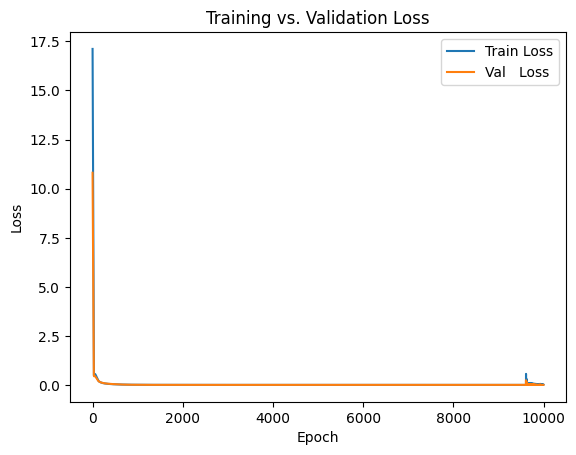

In [ ]:
model_L   = LogisticNet(input_dim)
criterion = nn.BCEWithLogitsLoss()
optimizer = torch.optim.Adam(model_L.parameters(), lr=0.01)

tol        = 1e-4
max_epochs = 10000

train_losses = []
val_losses   = []

for epoch in range(1, max_epochs+1):
    model_L.train()
    optimizer.zero_grad()
    logits     = model_L(X_train_tensor).squeeze()
    loss       = criterion(logits, y_train_tensor)
    loss.backward()
    optimizer.step()

    # record train loss
    train_losses.append(loss.item())

    # compute & record validation loss
    model_L.eval()
    with torch.no_grad():
        val_logits = model_L(X_val_tensor).squeeze()
        val_loss   = criterion(val_logits, y_val_tensor)
    val_losses.append(val_loss.item())

    # convergence check
    with torch.no_grad():
        weights = model_L.linear.weight.t()
        bias    = model_L.linear.bias

        cond_w = torch.max(torch.abs(weights - w_target)) < tol
        cond_b = torch.abs(bias - b_target) < tol

        if cond_w and cond_b:
            print(f"Converged to StatsModels weights at epoch {epoch}\n")
            break
else:
    print(f"No convergence within {max_epochs} epochs\n")

# Evaluate PyTorch model performance
model_L.eval()
with torch.no_grad():
    train_probs = torch.sigmoid(model_L(X_train_tensor).squeeze()).numpy()
    val_probs   = torch.sigmoid(model_L(X_val_tensor).squeeze()).numpy()

print(f"PyTorch Train AUC: {roc_auc_score(y_train, train_probs):.4f}")
print(f"PyTorch Val   AUC: {roc_auc_score(y_val,   val_probs):.4f}")

# Plot loss curves
plt.figure()
plt.plot(train_losses, label='Train Loss')
plt.plot(val_losses,   label='Val   Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training vs. Validation Loss')
plt.legend()
plt.show()

The above loss curve indicates that the convergence is faster. Both train and val losses plunge from double‐digits down to almost zero within the first few hundred epochs. After that, they basically flat-line at near zero for the remaining 9,000+ epochs. Also, there is no obvious overfitting. The training and validation losses track almost perfectly, and your AUCs (0.8730 vs. 0.8683) are nearly identical. That tells the model generalizes cleanly.

In [ ]:
model_L.state_dict()

OrderedDict([('linear.weight',
              tensor([[-0.7415,  0.4487,  0.3170, -0.0066,  0.4045]])),
             ('linear.bias', tensor([-6.2633]))])

In [ ]:
weight_arr = model_L.linear.weight.detach().cpu().numpy().flatten()
bias_val   = model_L.linear.bias.detach().cpu().numpy().item()

if hasattr(X_train, 'columns'):
    feature_names = X_train.columns.tolist()
else:
    feature_names = [f'x{i}' for i in range(X_train.shape[1])]

coef_series = pd.Series(
    data=np.concatenate([[bias_val], weight_arr]),
    index=['Intercept'] + feature_names
)

print("LogisticNet coefficients:")
print(coef_series)

LogisticNet coefficients:
Intercept               -6.263308
equity_to_assets        -0.741535
roa                      0.448656
liabilities_to_assets    0.316987
interest_coverage       -0.006603
debt_to_capital          0.404529
dtype: float64


In [ ]:
print("StatsModels coefficients:")
print(sm_train.params, "\n")

StatsModels coefficients:
const                   -7.668867
equity_to_assets         0.869611
roa                      0.259948
liabilities_to_assets    1.899983
interest_coverage       -0.000325
debt_to_capital          0.401107
dtype: float64 



The above comparison between LogisticNet coefficients and StatsModels coefficients shows noticeable different in some variables. I tried different learning rates and epochs, but still hard to converge them to the same. However, after we apply the StandardScaler method in the next section, this problem will be solved.

## 3.4 Use *scikit-learn* standardscaler

### 3.4.1 Logistic using StatsModels

In [ ]:
# Scale features using StatsModels
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_val_scaled   = scaler.transform(X_val)

# Re-fit StatsModels on the scaled data
Xtsm = sm.add_constant(X_train_scaled)
sm_scaled = sm.Logit(y_train, Xtsm).fit(disp=False)

# AUC on scaled data
train_auc_scaled = roc_auc_score(y_train, sm_scaled.predict(Xtsm))
Xvsm = sm.add_constant(X_val_scaled)
val_auc_scaled   = roc_auc_score(y_val,   sm_scaled.predict(Xvsm))

print("StatsModels (scaled) Train AUC:", f"{train_auc_scaled:.4f}")
print("StatsModels (scaled) Val   AUC:", f"{val_auc_scaled:.4f}\n")

print("StatsModels (scaled) coefficients:")
print(sm_scaled.params, "\n")


StatsModels (scaled) Train AUC: 0.8534
StatsModels (scaled) Val   AUC: 0.8564

StatsModels (scaled) coefficients:
const   -6.082430
x1       0.253661
x2       0.058848
x3       0.518527
x4      -0.538578
x5       0.399699
dtype: float64 



In [ ]:
# Convert scaled‐coef back to original feature scale
coef_s   = sm_scaled.params.values
b_s, w_s = coef_s[0], coef_s[1:]

# back‐transform:
w_orig = w_s / scaler.scale_
b_orig = b_s - (w_s * scaler.mean_ / scaler.scale_).sum()

orig_index = ["Intercept"] + (X_train.columns.tolist() if hasattr(X_train, "columns")
                              else [f"x{i}" for i in range(X_train.shape[1])])
coef_orig = pd.Series([b_orig, *w_orig], index=orig_index)
print("Back-converted StatsModels coefficients:")
print(coef_orig, "\n")

# Compare to your original sm_train.params:
print("Original StatsModels coefficients:")
print(sm_train.params, "\n")

Back-converted StatsModels coefficients:
Intercept               -7.668867
equity_to_assets         0.869611
roa                      0.259948
liabilities_to_assets    1.899983
interest_coverage       -0.000325
debt_to_capital          0.401107
dtype: float64 

Original StatsModels coefficients:
const                   -7.668867
equity_to_assets         0.869611
roa                      0.259948
liabilities_to_assets    1.899983
interest_coverage       -0.000325
debt_to_capital          0.401107
dtype: float64 



The StatsModel results are exactly the same whether or not the X variables are scaled. This means scaling does not affect the StatsModel method.

### 3.4.2 Logistic using Neural Nets

No convergence within 10000 epochs

PyTorch Train AUC: 0.8534
PyTorch Val   AUC: 0.8564


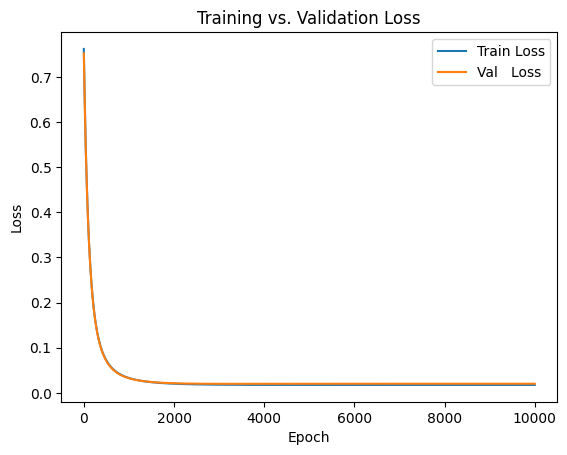

In [ ]:
# Prepare tensors
Xtr_t = torch.tensor(X_train_scaled, dtype=torch.float32)
ytr_t = torch.tensor(y_train.values if hasattr(y_train, "values") else y_train,
                    dtype=torch.float32)
Xvl_t = torch.tensor(X_val_scaled,   dtype=torch.float32)
yvl_t = torch.tensor(y_val.values if hasattr(y_val, "values") else y_val,
                    dtype=torch.float32)

model_L_scaled = LogisticNet(Xtr_t.shape[1])
criterion = nn.BCEWithLogitsLoss()
optimizer = torch.optim.Adam(model_L_scaled.parameters(), lr=0.01)

tol        = 1e-4
max_epochs = 10000

train_losses = []
val_losses   = []

for epoch in range(1, max_epochs+1):
    model_L_scaled.train()
    optimizer.zero_grad()
    logits     = model_L_scaled(Xtr_t).squeeze()
    loss       = criterion(logits, ytr_t)
    loss.backward()
    optimizer.step()

    # record train loss
    train_losses.append(loss.item())

    # compute & record validation loss
    model_L_scaled.eval()
    with torch.no_grad():
        val_logits = model_L_scaled(Xvl_t).squeeze()
        val_loss   = criterion(val_logits, yvl_t)
    val_losses.append(val_loss.item())

    # convergence check
    with torch.no_grad():
        weights = model_L_scaled.linear.weight.t()
        bias    = model_L_scaled.linear.bias

        cond_w = torch.max(torch.abs(weights - w_target)) < tol
        cond_b = torch.abs(bias - b_target) < tol

        if cond_w and cond_b:
            print(f"Converged to StatsModels weights at epoch {epoch}\n")
            break
else:
    print(f"No convergence within {max_epochs} epochs\n")

# Evaluate PyTorch model performance
model_L_scaled.eval()
with torch.no_grad():
    train_probs = torch.sigmoid(model_L_scaled(Xtr_t).squeeze()).numpy()
    val_probs   = torch.sigmoid(model_L_scaled(Xvl_t).squeeze()).numpy()

print(f"PyTorch Train AUC: {roc_auc_score(ytr_t, train_probs):.4f}")
print(f"PyTorch Val   AUC: {roc_auc_score(yvl_t,   val_probs):.4f}")

# Plot loss curves
plt.figure()
plt.plot(train_losses, label='Train Loss')
plt.plot(val_losses,   label='Val   Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training vs. Validation Loss')
plt.legend()
plt.show()


From this training and validation loss curve, we can see:


1. Rapid early convergence: Loss plunges from ~0.7 to under 0.05 within the first few hundred epochs, showing that Adam + scaling lets the net learn the bulk of the signal very quickly.
2. No overfitting: The orange (validation) and blue (training) curves lie almost on top of each other all the way down, so the model generalizes cleanly.



In [ ]:
model_L_scaled.state_dict()

OrderedDict([('linear.weight',
              tensor([[ 0.2536,  0.0588,  0.5185, -0.5386,  0.3997]])),
             ('linear.bias', tensor([-6.0824]))])

In [ ]:
# Extract PyTorch weights & bias and back-transform
w_s_t = model_L_scaled.linear.weight.detach().cpu().numpy().flatten()
b_s_t = model_L_scaled.linear.bias.detach().cpu().numpy().item()

w_t_orig = w_s_t / scaler.scale_
b_t_orig = b_s_t - (w_s_t * scaler.mean_ / scaler.scale_).sum()

coef_torch_orig = pd.Series([b_t_orig, *w_t_orig], index=orig_index)
print("Back-converted PyTorch coefficients:")
print(coef_torch_orig, "\n")

# Compare to original StatsModels:
print("Original StatsModels coefficients:")
print(sm_train.params)

Back-converted PyTorch coefficients:
Intercept               -7.668810
equity_to_assets         0.869569
roa                      0.259945
liabilities_to_assets    1.899937
interest_coverage       -0.000325
debt_to_capital          0.401106
dtype: float64 

Original StatsModels coefficients:
const                   -7.668867
equity_to_assets         0.869611
roa                      0.259948
liabilities_to_assets    1.899983
interest_coverage       -0.000325
debt_to_capital          0.401107
dtype: float64


We can see that after scaling the X variables and converting the bias and weights back to their non-scaled equivalents, the logistic coefficients are very close to the StatsModels coefficients. This means that scaling the X variables is essential when using logistic regression with neural networks.

## 3.5 Simple Neural Nets (6-6-1)

In [ ]:
class SimpleNet(nn.Module):
    def __init__(self, input_dim):
        super().__init__()
        self.fc1  = nn.Linear(input_dim, 6) # hidden layer with 6 nodes
        self.relu = nn.ReLU() #non-linear activation
        self.fc2  = nn.Linear(6, 1) # output layer with 1 node

    def forward(self, x):
        x = self.fc1(x)
        x = self.relu(x)
        x = self.fc2(x)
        return x

In [ ]:
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_val_scaled   = scaler.transform(X_val)

# Convert to PyTorch tensors
X_train_t = torch.tensor(X_train_scaled, dtype=torch.float32)
y_train_t = torch.tensor(
    y_train.values if hasattr(y_train, 'values') else y_train,
    dtype=torch.float32
)
X_val_t = torch.tensor(X_val_scaled, dtype=torch.float32)
y_val_t = torch.tensor(
    y_val.values if hasattr(y_val, 'values') else y_val,
    dtype=torch.float32
)

input_dim  = X_train_t.shape[1]

I also tried different learning rates and epochs here. A combination of lr=0.01 and epochs=10,000 will lead to overfitting. So, I lower the epochs number and choose lr-0.01 and epochs=600.

No convergence within 600 epochs
PyTorch Train AUC: 0.9192
PyTorch Val   AUC: 0.9204


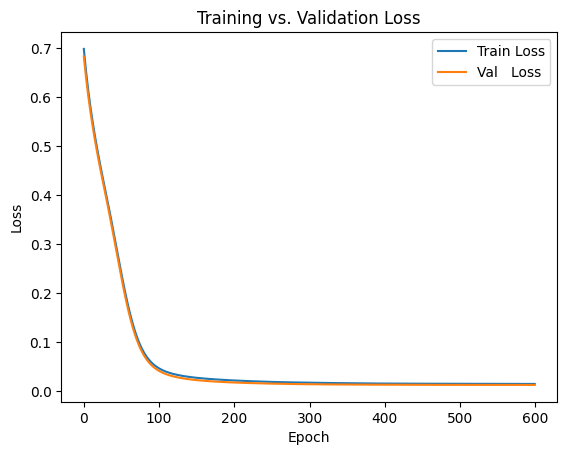

In [ ]:
model_S = SimpleNet(input_dim)
criterion = nn.BCEWithLogitsLoss()
optimizer = optim.Adam(model_S.parameters(), lr=0.01)

tol        = 1e-4
max_epochs = 600
prev_loss  = float('inf')

train_losses = []
val_losses   = []

for epoch in range(1, max_epochs+1):
    model_S.train()
    optimizer.zero_grad()
    logits     = model_S(X_train_t).squeeze()
    loss       = criterion(logits, y_train_t)
    loss.backward()
    optimizer.step()

    # record train loss
    train_losses.append(loss.item())

    # compute & record validation loss
    model_S.eval()
    with torch.no_grad():
        val_logits = model_S(X_val_t).squeeze()
        val_loss   = criterion(val_logits, y_val_t)
    val_losses.append(val_loss.item())

    if abs(prev_loss - loss.item()) < tol:
      print(f"Converged at epoch {epoch}")
      break
      prev_loss = loss.item()

else:
    print(f"No convergence within {max_epochs} epochs")


# Evaluate PyTorch model performance
model_S.eval()
with torch.no_grad():
    train_probs = torch.sigmoid(model_S(X_train_t).squeeze()).numpy()
    val_probs   = torch.sigmoid(model_S(X_val_t).squeeze()).numpy()

print(f"PyTorch Train AUC: {roc_auc_score(y_train_t, train_probs):.4f}")
print(f"PyTorch Val   AUC: {roc_auc_score(y_val_t,   val_probs):.4f}")

# Plot loss curves
plt.figure()
plt.plot(train_losses, label='Train Loss')
plt.plot(val_losses,   label='Val   Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training vs. Validation Loss')
plt.legend()
plt.show()


The above traing and validation loss curve shows a faster and cleaner convergence. Loss plummets from ~0.7 to near zero in under 100 epochs (vs. thousands before), so scaling really speeds things up. Also, the performance is really strong and stable. Train AUC = 0.9192 and Val AUC = 0.9204—both higher than the unscaled run and almost identical to each other with very little overfitting.

In [ ]:
model_S.state_dict()

OrderedDict([('fc1.weight',
              tensor([[ 0.9975,  0.8022, -1.0625, -0.5269, -1.0213],
                      [ 0.2384,  0.0892,  0.3552, -0.5453,  0.7326],
                      [ 0.3786, -1.8336, -0.4265,  0.4117, -0.3390],
                      [ 0.0808,  0.0331, -0.0775, -0.0413, -0.0620],
                      [-0.4442,  2.4333,  0.1615, -1.3117,  0.4015],
                      [-0.0127,  0.0531, -0.0299, -0.0449,  0.0095]])),
             ('fc1.bias',
              tensor([ 1.4427, -0.2156,  1.5404, -0.3936,  1.4559, -0.0835])),
             ('fc2.weight',
              tensor([[-1.3041,  0.5172, -1.0021,  0.0970, -1.5345,  0.1463]])),
             ('fc2.bias', tensor([-0.9265]))])

## 3.6 Add a Drop Layer to Simple Neural Nets

In [ ]:
class SimpleNetDropout(nn.Module):
    def __init__(self, input_dim, p_drop=0.5):
        super().__init__()
        self.fc1     = nn.Linear(input_dim, 6)
        self.relu    = nn.ReLU()
        self.dropout = nn.Dropout(p_drop)
        self.fc2     = nn.Linear(6, 1)

    def forward(self, x):
        x = self.fc1(x)
        x = self.relu(x)
        x = self.dropout(x)
        x = self.fc2(x)
        return x

No convergence within 1000 epochs
PyTorch Train AUC: 0.9244
PyTorch Val   AUC: 0.9009


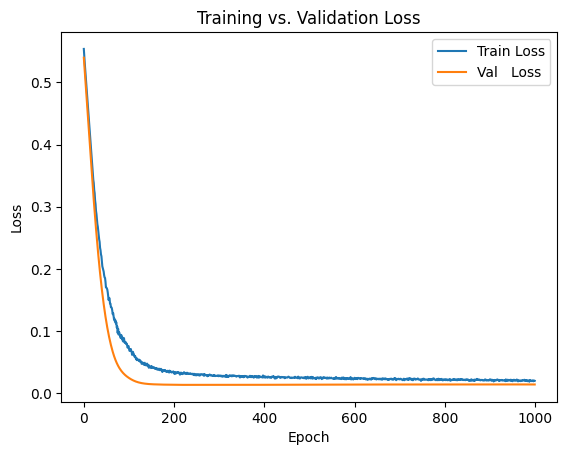

In [ ]:
model_SD     = SimpleNetDropout(input_dim,p_drop=0.5)
criterion = nn.BCEWithLogitsLoss()
optimizer = optim.Adam(model_SD.parameters(), lr=0.01)

# Training loop with convergence check
tol        = 1e-4
max_epochs = 1000
prev_loss  = float('inf')

train_losses = []
val_losses   = []

for epoch in range(1, max_epochs+1):
    model_SD.train()
    optimizer.zero_grad()
    logits     = model_SD(X_train_t).squeeze()
    loss       = criterion(logits, y_train_t)
    loss.backward()
    optimizer.step()

    # record train loss
    train_losses.append(loss.item())

    # compute & record validation loss
    model_SD.eval()
    with torch.no_grad():
        val_logits = model_SD(X_val_t).squeeze()
        val_loss   = criterion(val_logits, y_val_t)
    val_losses.append(val_loss.item())

    if abs(prev_loss - loss.item()) < tol:
      print(f"Converged at epoch {epoch}")
      break
      prev_loss = loss.item()

else:
    print(f"No convergence within {max_epochs} epochs")


# Evaluate PyTorch model performance
model_SD.eval()
with torch.no_grad():
    train_probs = torch.sigmoid(model_SD(X_train_t).squeeze()).numpy()
    val_probs   = torch.sigmoid(model_SD(X_val_t).squeeze()).numpy()

print(f"PyTorch Train AUC: {roc_auc_score(y_train_t, train_probs):.4f}")
print(f"PyTorch Val   AUC: {roc_auc_score(y_val_t,   val_probs):.4f}")

# Plot loss curves
plt.figure()
plt.plot(train_losses, label='Train Loss')
plt.plot(val_losses,   label='Val   Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training vs. Validation Loss')
plt.legend()
plt.show()

The above training and validation loss curve shows
1.  Slower and noiser training loss: The blue “Train Loss” curve
descends more gradually and shows jitter—dropout randomly zeroes out half the hidden units each batch, so the model has to learn around that noise.

2. Validation loss sits below training : Because dropout is only active during training, the “Val Loss” (orange) is consistently lower and much smoother.

3. Still converges to low loss : Despite the added noise, both curves flatten out around near‐zero loss by ~200–300 epochs, indicating you’ve retained strong learning capacity.


In [ ]:
model_SD.state_dict()

OrderedDict([('fc1.weight',
              tensor([[ 0.6261,  0.2954, -0.4571,  0.0113,  0.0847],
                      [-0.0656,  0.3021, -0.5243, -0.0148, -0.1759],
                      [-0.3447, -0.2677, -0.2157,  0.3739, -0.0180],
                      [ 0.1573,  1.4335, -0.1121, -0.3254, -0.0519],
                      [ 0.2435, -0.0799, -0.2432, -0.7223, -0.2049],
                      [-0.1235,  0.9058, -0.4149,  0.1982, -0.0890]])),
             ('fc1.bias',
              tensor([1.0741, 1.1502, 0.4320, 0.9674, 0.9200, 1.0877])),
             ('fc2.weight',
              tensor([[-1.4961, -1.2480, -0.4532, -1.3049, -1.3976, -1.2646]])),
             ('fc2.bias', tensor([-2.0150]))])

# Step 4. Conclusion: Impression of the Neural Net

When testing different hyperparameters, we copy the current file and work in a separate file to avoid mixing them up.

## 4.1 Comments on multiple runs

The neural net structure is pretty flexible. Changing different hyperparameters can cause different results. Within the class object of a neural net, we can change our number of nodes easily, or adding or dropping layers is pretty simple. Also, within the class structure, we can change our activation function easily and rerun the whole training and validation process. The training and validation process is pretty stable and can finish its run within 1 min, whatever parameters I change.

## 4.2 Findings on different number of nodes

Based on the simple neural net, we also tried different numbers of nodes in the hidden layer—10, 50, and 100. We found that a higher number of nodes yielded a higher AUC. Adding more hidden units boosts the network’s capacity to capture complex, nonlinear patterns and feature interactions in the data. Each extra node can learn a new aspect of how the input ratios relate to default risk, enabling the model to carve out a more accurate decision boundary—and that typically shows up as a higher AUC.

## 4.3 Findings on different activation functions

Based on the simple neural net, we also tried 3 other activation functions which are Sigmoid, Tanh and Softmax. The AUC that we got for Sigmoid and Tanh is pretty similar to Relu, which are around 0.9. However, the Softmax function only give me AUC around 0.1 which is pretty low. The reason might be Softmax isn’t designed as a hidden-layer nonlinearity. It forces 6 units to form a single probability distribution (summing to one), which drastically limits their independent representational power and quickly drives them into saturation, killing gradients. By contrast, element-wise activations like sigmoid or tanh let each unit respond and learn on its own, so they preserve the signal needed for good AUC.

## 4.4 Findings on different optimizations

Based on the simple neural net, we also tried SGD and RMSprop. RMSprop outperforms Adam and SGD here. The reason might because it adaptively scales each weight’s learning rate based on its recent gradient magnitude, which smooths out the erratic updates you get from a small, dropout‐regularized network and imbalanced financial‐ratio inputs. Its simpler per‐parameter adjustment often converges more steadily than Adam’s extra momentum and bias corrections or SGD’s one‐size‐fits‐all step size.